In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


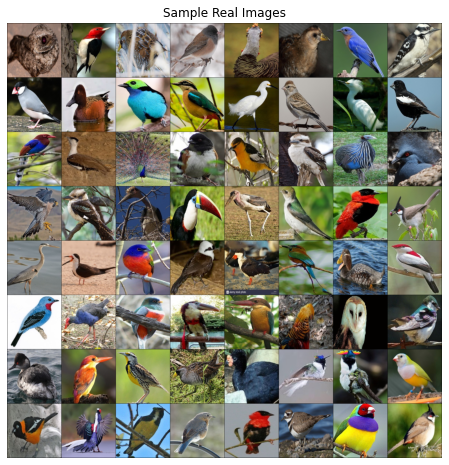

In [3]:
DATA_DIR = "data/consolidated/"

BATCH_SIZE = 64
SAMPLE_SIZE = 64

# Images are 3 x 224 x 224
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=DATA_DIR,
                               transform=data_transforms)

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False)

# Plot samples
sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Real Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0][:SAMPLE_SIZE], padding=1, normalize=True), (1, 2, 0)));

In [4]:
# Weight initialization as suggested in literature
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
def convtrans_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),    # bias not needed because of BatchNorm
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, LATENT_SIZE):
        super().__init__()
        self.main = nn.Sequential(
            convtrans_block(LATENT_SIZE, 512, kernel_size=4, stride=4, padding=0),
            convtrans_block(512, 256, kernel_size=4, stride=4, padding=1),
            convtrans_block(256, 128, kernel_size=4, stride=2, padding=1),
            convtrans_block(128, 64, kernel_size=4, stride=2, padding=1),
            convtrans_block(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

LATENT_SIZE = 128
    
generator = Generator(LATENT_SIZE)
generator.apply(weights_init)
generator.to(device)

summary(generator, (LATENT_SIZE, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4          [-1, 256, 14, 14]       2,097,152
       BatchNorm2d-5          [-1, 256, 14, 14]             512
              ReLU-6          [-1, 256, 14, 14]               0
   ConvTranspose2d-7          [-1, 128, 28, 28]         524,288
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
  ConvTranspose2d-10           [-1, 64, 56, 56]         131,072
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
  ConvTranspose2d-13         [-1, 64, 112, 112]          65,536
      BatchNorm2d-14         [-1, 64, 1

In [6]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),    # bias not needed because of BatchNorm
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            conv_block(3, 64, kernel_size=4, stride=2, padding=0),
            conv_block(64, 128, kernel_size=4, stride=2, padding=0),
            conv_block(128, 256, kernel_size=4, stride=2, padding=0),
            conv_block(256, 256, kernel_size=4, stride=2, padding=0),
            conv_block(256, 256, kernel_size=4, stride=2, padding=0),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=0),
        )

    def forward(self, x):
        return self.main(x)
    
critic = Critic()
critic.apply(weights_init)
critic.to(device)

summary(critic, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           3,072
       BatchNorm2d-2         [-1, 64, 111, 111]             128
         LeakyReLU-3         [-1, 64, 111, 111]               0
            Conv2d-4          [-1, 128, 54, 54]         131,072
       BatchNorm2d-5          [-1, 128, 54, 54]             256
         LeakyReLU-6          [-1, 128, 54, 54]               0
            Conv2d-7          [-1, 256, 26, 26]         524,288
       BatchNorm2d-8          [-1, 256, 26, 26]             512
         LeakyReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 12, 12]       1,048,576
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        LeakyReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13            [-1, 256, 5, 5]       1,048,576
      BatchNorm2d-14            [-1, 25

In [7]:
# Change these lines when training from saved file (0 if from scratch)
SAVED_EPOCH = 90
FROM_SAVED = True

PREFIX = "models/WGAN-GP/WGAN-GP_"
IMG_PATH = PREFIX + "img_list.pickle"
GEN_LOSSES_PATH = PREFIX + "gen_losses.pickle"
CRI_LOSSES_PATH = PREFIX + "cri_losses.pickle"
GIF_PATH = PREFIX + "images.gif"
INIT_WEIGHTS_PATH = PREFIX + "initialization_"
FIXED_NOISE_PATH = PREFIX + "fixed_noise.pt"

In [8]:
if FROM_SAVED:
    GEN_PATH = PREFIX + f"gen_epoch{SAVED_EPOCH:0=3d}.pt"
    CRI_PATH = PREFIX + f"cri_epoch{SAVED_EPOCH:0=3d}.pt"

    generator.load_state_dict(torch.load(GEN_PATH))
    critic.load_state_dict(torch.load(CRI_PATH))
    fixed_noise = torch.load(FIXED_NOISE_PATH)

    with open(IMG_PATH, 'rb') as f:
        img_list = pickle.load(f)
    with open(GEN_LOSSES_PATH, 'rb') as f:
        gen_losses = pickle.load(f)
    with open(CRI_LOSSES_PATH, 'rb') as f:
        cri_losses = pickle.load(f)

    ITERS = SAVED_EPOCH * 590
else:
    SAVED_EPOCH = 0
    ITERS = 0
    img_list = []
    gen_losses = []
    cri_losses = []
    
    try:
        # Comment out fail() when loading saved noise/init weights (Useful when comparing between architectures)
        fail()
        fixed_noise = torch.load(FIXED_NOISE_PATH)
        generator.load_state_dict(torch.load(INIT_WEIGHTS_PATH + "gen.pt"))
        critic.load_state_dict(torch.load(INIT_WEIGHTS_PATH + "cri.pt"))
        print("Previous fixed noise and initialization for gen/cri loaded!")
    except:      
        # Fixed noise vector we'll use to track image generation evolution
        fixed_noise = torch.randn(SAMPLE_SIZE, LATENT_SIZE, 1, 1, device=device)
        torch.save(fixed_noise, FIXED_NOISE_PATH)
        
        generator = Generator(LATENT_SIZE)
        generator.apply(weights_init)
        torch.save(generator.state_dict(), INIT_WEIGHTS_PATH + "gen.pt")

        critic = Critic()
        critic.apply(weights_init)
        torch.save(critic.state_dict(), INIT_WEIGHTS_PATH + "cri.pt")
        print("New fixed noise and initialization for gen/cri generated & saved!")

generator.to(device)
summary(generator, (LATENT_SIZE, 1, 1))    
    
critic.to(device)
summary(critic, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4          [-1, 256, 14, 14]       2,097,152
       BatchNorm2d-5          [-1, 256, 14, 14]             512
              ReLU-6          [-1, 256, 14, 14]               0
   ConvTranspose2d-7          [-1, 128, 28, 28]         524,288
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
  ConvTranspose2d-10           [-1, 64, 56, 56]         131,072
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
  ConvTranspose2d-13         [-1, 64, 112, 112]          65,536
      BatchNorm2d-14         [-1, 64, 1

Begin training...
Epoch (91/100) Iteration (53100) Loss_G: -170.7489 Loss_C: -787.7838 C_real: 1006.1545 C_fake: 131.9317
Epoch (91/100) Iteration (53150) Loss_G: -608.4848 Loss_C: -769.4506 C_real: 1510.5160 C_fake: 689.5192
Epoch (91/100) Iteration (53200) Loss_G: -437.0056 Loss_C: -1028.1292 C_real: 1385.6681 C_fake: 214.8499
Epoch (91/100) Iteration (53250) Loss_G: -133.5165 Loss_C: -984.4780 C_real: 1090.5367 C_fake: 37.6475
Epoch (91/100) Iteration (53300) Loss_G: 187.3238 Loss_C: -1086.2756 C_real: 1134.5632 C_fake: 6.1120
Epoch (91/100) Iteration (53350) Loss_G: -2702.0986 Loss_C: -376.8501 C_real: 3441.1511 C_fake: 2905.8367
Epoch (91/100) Iteration (53400) Loss_G: -1161.9372 Loss_C: -754.6876 C_real: 2088.8665 C_fake: 1306.1321
Epoch (91/100) Iteration (53450) Loss_G: -659.7133 Loss_C: -633.7056 C_real: 1734.0876 C_fake: 1046.4490
Epoch (91/100) Iteration (53500) Loss_G: -195.5362 Loss_C: -1301.0250 C_real: 1487.2058 C_fake: 154.1670
Epoch (91/100) Iteration (53550) Loss_G: 3

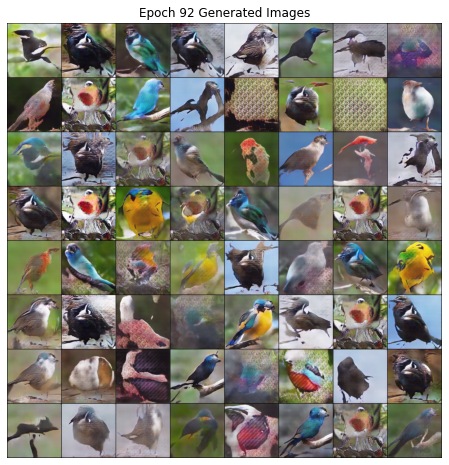

Epoch (93/100) Iteration (54300) Loss_G: -276.2750 Loss_C: -405.0129 C_real: 1555.9514 C_fake: 587.5092
Epoch (93/100) Iteration (54350) Loss_G: 100.2101 Loss_C: -1148.0824 C_real: 1353.9399 C_fake: 93.0515
Epoch (93/100) Iteration (54400) Loss_G: 266.1269 Loss_C: -934.0276 C_real: 932.9213 C_fake: -77.9067
Epoch (93/100) Iteration (54450) Loss_G: -60.9250 Loss_C: -824.8920 C_real: 1094.0941 C_fake: 136.7791
Epoch (93/100) Iteration (54500) Loss_G: -483.1327 Loss_C: -576.9304 C_real: 1678.5117 C_fake: 1035.5640
Epoch (93/100) Iteration (54550) Loss_G: 185.3002 Loss_C: -1077.4895 C_real: 1272.5026 C_fake: 121.4284
Epoch (93/100) Iteration (54600) Loss_G: 96.6445 Loss_C: -796.8317 C_real: 495.6928 C_fake: -362.0794
Epoch (93/100) Iteration (54650) Loss_G: -3872.4962 Loss_C: 231.9490 C_real: 4093.8264 C_fake: 4267.5176
Epoch (93/100) Iteration (54700) Loss_G: -310.7566 Loss_C: -925.4345 C_real: 2119.4392 C_fake: 1133.2419
Epoch (93/100) Iteration (54750) Loss_G: -242.9890 Loss_C: -963.542

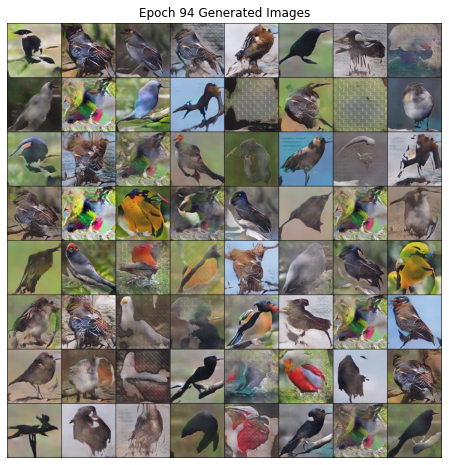

Epoch (95/100) Iteration (55500) Loss_G: -452.6021 Loss_C: -1308.9789 C_real: 1511.1205 C_fake: 133.0067
Epoch (95/100) Iteration (55550) Loss_G: -3307.3010 Loss_C: 130.7704 C_real: 3707.4580 C_fake: 3743.4812
Epoch (95/100) Iteration (55600) Loss_G: 125.9517 Loss_C: -1179.7140 C_real: 1499.0967 C_fake: 272.8903
Epoch (95/100) Iteration (55650) Loss_G: -838.9384 Loss_C: -1230.9209 C_real: 1717.9841 C_fake: 360.2065
Epoch (95/100) Iteration (55700) Loss_G: -279.3533 Loss_C: -1094.8083 C_real: 1048.5129 C_fake: -107.8567
Epoch (95/100) Iteration (55750) Loss_G: -667.8321 Loss_C: -801.5652 C_real: 1292.1937 C_fake: 441.5376
Epoch (95/100) Iteration (55800) Loss_G: -204.8829 Loss_C: -1267.7367 C_real: 1313.2983 C_fake: -22.7319
Epoch (95/100) Iteration (55850) Loss_G: -1581.0086 Loss_C: -717.1206 C_real: 3195.8555 C_fake: 2387.1074
Epoch (95/100) Iteration (55900) Loss_G: 173.7707 Loss_C: -1704.8718 C_real: 1764.6360 C_fake: 8.7988
Epoch (95/100) Iteration (55950) Loss_G: 142.1060 Loss_C: 

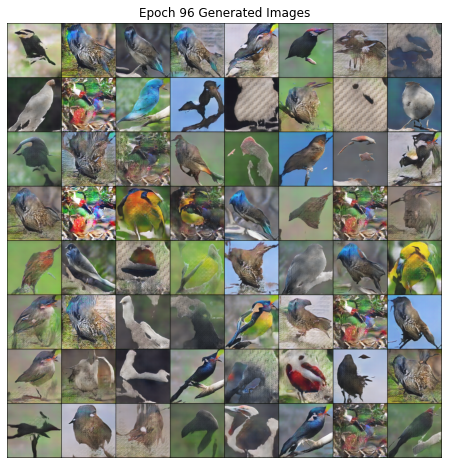

Epoch (97/100) Iteration (56650) Loss_G: 157.2894 Loss_C: -1158.2477 C_real: 1946.7643 C_fake: 679.6010
Epoch (97/100) Iteration (56700) Loss_G: -1085.0831 Loss_C: -1109.9860 C_real: 2401.9392 C_fake: 1242.3942
Epoch (97/100) Iteration (56750) Loss_G: -222.7278 Loss_C: -1495.0776 C_real: 1817.1978 C_fake: 210.1294
Epoch (97/100) Iteration (56800) Loss_G: 68.8641 Loss_C: -492.5841 C_real: 883.8014 C_fake: 340.9821
Epoch (97/100) Iteration (56850) Loss_G: 119.3662 Loss_C: -1560.8384 C_real: 1776.0046 C_fake: 183.2288
Epoch (97/100) Iteration (56900) Loss_G: -230.4644 Loss_C: -1411.3391 C_real: 1622.8557 C_fake: 167.5098
Epoch (97/100) Iteration (56950) Loss_G: -534.2540 Loss_C: -1211.6317 C_real: 1799.6788 C_fake: 507.1998
Epoch (97/100) Iteration (57000) Loss_G: -408.8974 Loss_C: -1182.4009 C_real: 1528.9491 C_fake: 203.2765
Epoch (97/100) Iteration (57050) Loss_G: 361.3320 Loss_C: -1507.8878 C_real: 1087.3353 C_fake: -544.8433
Epoch (97/100) Iteration (57100) Loss_G: -278.7132 Loss_C: 

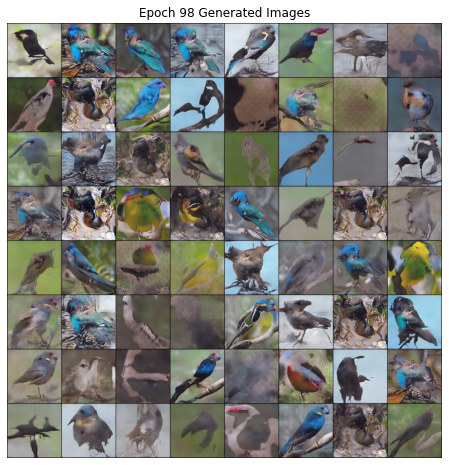

Epoch (99/100) Iteration (57850) Loss_G: -256.3531 Loss_C: -4807.5015 C_real: 5169.4180 C_fake: 250.4424
Epoch (99/100) Iteration (57900) Loss_G: 241.9910 Loss_C: -1063.9509 C_real: 1227.4700 C_fake: 33.4978
Epoch (99/100) Iteration (57950) Loss_G: -687.5594 Loss_C: -300.5934 C_real: 1238.7351 C_fake: 905.9882
Epoch (99/100) Iteration (58000) Loss_G: -950.6434 Loss_C: -1470.3921 C_real: 2416.1873 C_fake: 771.7963
Epoch (99/100) Iteration (58050) Loss_G: -879.4629 Loss_C: -342.3114 C_real: 2376.8132 C_fake: 1972.6641
Epoch (99/100) Iteration (58100) Loss_G: -226.4371 Loss_C: -1264.4321 C_real: 1463.6891 C_fake: 21.5437
Epoch (99/100) Iteration (58150) Loss_G: 445.7469 Loss_C: -1158.7311 C_real: 787.1680 C_fake: -485.2025
Epoch (99/100) Iteration (58200) Loss_G: -60.8377 Loss_C: -1152.7015 C_real: 1285.0444 C_fake: -18.3629
Epoch (99/100) Iteration (58250) Loss_G: -268.7597 Loss_C: -4162.2383 C_real: 4474.8379 C_fake: 266.4070
Epoch (99/100) Iteration (58300) Loss_G: 231.7229 Loss_C: -13

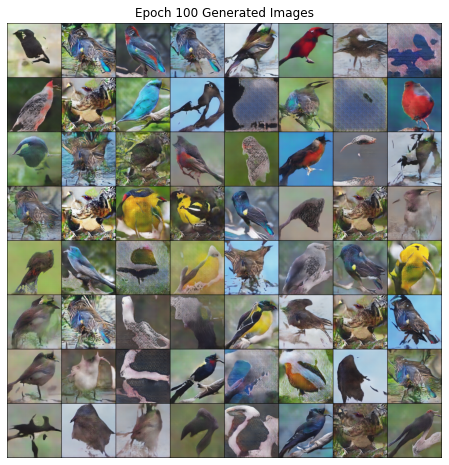

Finished training!


In [9]:
NUM_EPOCHS = 10

# Original WGAN-GP proposes having 5 critic updates and 1 generator update every iteration
# Here, we'll try more generator updates in case critic overpowers generator at later epochs
n_cri = 1
n_gen = 5
λ = 10
LR = 0.0002

optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerC= optim.Adam(critic.parameters(), lr=LR, betas=(0.5, 0.999))

print("Begin training...")

for epoch in range(SAVED_EPOCH + 1, SAVED_EPOCH + NUM_EPOCHS + 1):
    for real_batch, _ in data_loader:
        loss_cri_iter = 0
        loss_gen_iter = 0
        C_real_iter = 0
        C_fake_iter = 0
        
        for _ in range(n_cri):
            optimizerC.zero_grad()

            # Train with real data
            real_batch = real_batch.to(device)
            real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float, device=device)
            output_real = critic(real_batch).view(-1)
            C_real = output_real.mean()
        
            # Train with fake data
            noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1, device=device)
            fake_batch = generator(noise)
            fake_labels = torch.zeros_like(real_labels)           
            output_fake = critic(fake_batch.detach()).view(-1)  
            C_fake = output_fake.mean()
        
            # Gradient Penalty
            ϵ = torch.rand(real_batch.shape[0], 1, 1, 1, device=device, requires_grad=True)
            interpolated = real_batch * ϵ + fake_batch.detach() * (1 - ϵ)
            output_interpolated = critic(interpolated)
            gradient = torch.autograd.grad(inputs=interpolated,
                                           outputs=output_interpolated,
                                           grad_outputs=torch.ones_like(output_interpolated), 
                                           create_graph=True)[0]

            gradient = gradient.view(len(gradient), -1)
            grad_norm = gradient.norm(2, dim=1)
            gp = torch.mean((grad_norm - 1) ** 2)            
            
            # Update critic weights and store loss
            loss_cri = C_fake - C_real + λ * gp
            loss_cri.backward()
            optimizerC.step()
            C_real_iter += C_real.item()
            C_fake_iter += C_fake.item()
            loss_cri_iter += loss_cri.item()
        
        for _ in range(n_gen):
            optimizerG.zero_grad()
            noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1, device=device)
            fake_batch = generator(noise)
            output_fake = critic(fake_batch).view(-1)
            loss_gen = -output_fake.mean()
        
            # Update generator weights and store loss
            loss_gen.backward()
            optimizerG.step()
            loss_gen_iter += loss_gen.item()
        
        C_real_iter /= n_cri
        C_fake_iter /= n_cri
        loss_cri_iter /= n_cri
        loss_gen_iter /= n_gen
        
        # Track losses for later use
        gen_losses.append(loss_gen_iter)
        cri_losses.append(loss_cri_iter)
        
        if (ITERS % 50 == 0):
            print(f"Epoch ({epoch}/{SAVED_EPOCH + NUM_EPOCHS})",
                  f"Iteration ({ITERS})",
                  f"Loss_G: {loss_gen_iter:.4f}",
                  f"Loss_C: {loss_cri_iter:.4f}",
                  f"C_real: {C_real:.4f}",  
                  f"C_fake: {C_fake:.4f}")
        ITERS += 1
    
    ### Store loss and track image evolution (tracking image every 2 epochs to reduce memory usage)
    if epoch % 2 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, nrow=8, normalize=True))
        
        # Display generated images during training
        plt.figure(figsize=(8, 8)); plt.axis("off"); plt.title(f"Epoch {epoch} Generated Images")
        plt.imshow(np.transpose(img_list[-1], (1,2,0)));
        plt.show()
    
    # Save weights every 5 epochs
    if epoch % 5 == 0:
        torch.save(generator.state_dict(), PREFIX + f"gen_epoch{epoch:0=3d}.pt")
        torch.save(critic.state_dict(), PREFIX + f"cri_epoch{epoch:0=3d}.pt")  
        
print("Finished training!")

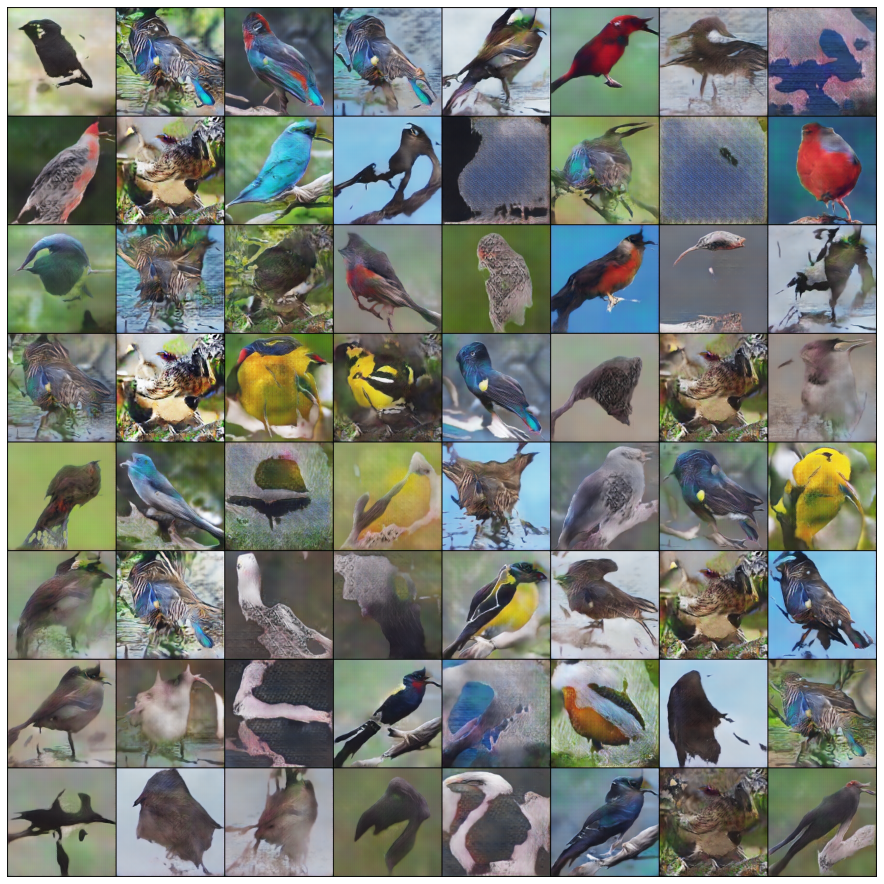

In [10]:
# Last generated image.
plt.figure(figsize=(16, 16)); plt.axis("off");
fake_sample = img_list[-1]
plt.imshow(np.transpose(fake_sample,(1,2,0)));

In [13]:
with open(IMG_PATH, 'wb') as f:
    pickle.dump(img_list, f, pickle.HIGHEST_PROTOCOL)
with open(GEN_LOSSES_PATH, 'wb') as f:
    pickle.dump(gen_losses, f, pickle.HIGHEST_PROTOCOL)
with open(CRI_LOSSES_PATH, 'wb') as f:
    pickle.dump(cri_losses, f, pickle.HIGHEST_PROTOCOL)

In [14]:
%%capture
fig = plt.figure(figsize=(16, 16)); plt.axis("off"); plt.title("Generated Images")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save(GIF_PATH, writer='imagemagick', fps=2)
HTML(ani.to_jshtml())

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()